In [106]:
# Note that all the code is basically taken from Gustavo Patow's WholeBrain module (https://github.com/dagush/WholeBrain)

# Load all the packages needed for analyses
import sys
import numpy as np
import scipy.io as sio
from numba import jit
import matplotlib.pyplot as plt
import pickle

# Set up Hopf as our model 
import WholeBrain.Models.supHopf as Hopf
from WholeBrain.simulate_SimOnly import Tmaxneuronal
Hopf.initialValue = 0.1
neuronalModel = Hopf

# Set up our integrator
import WholeBrain.Integrator_EulerMaruyama as myIntegrator
integrator = myIntegrator
integrator.neuronalModel = neuronalModel
integrator.verbose = False
integrator.clamping = False

# Set up the integration parameters
dt = 5e-5
# tmax is equal to the number of timepoints: 193
tmax= 193
ds = 1e-4
Tmaxneuronal = int((tmax+dt))

import WholeBrain.simulate_SimOnly as simulateBOLD
simulateBOLD.warmUp = True
simulateBOLD.integrator = integrator
simulateBOLD.warmUpFactor = 606./2000.

# Set up the code to obtain the variables we want to maximize similarity to empirical FC
import WholeBrain.Observables.FC as FC
import WholeBrain.Observables.phFCD as phFCD
import WholeBrain.Optimizers.ParmSeep as ParmSeep
ParmSeep.simulateBOLD = simulateBOLD
ParmSeep.integrator = integrator
ParmSeep.verbose = True

# set BOLD filter settings
import WholeBrain.Utils.filteredPowerSpectralDensity as filtPowSpectr
import WholeBrain.BOLDFilters as BOLDfilters

# These filters are applied in the filtPowSpectr function that we use to extract the intrinsic frequencies of each region.
# They are also applied to process the FC and swFCD and phFCD, but you can set the corresponding parameter to False later on. 0.04-0.07 Hz common to extract intrinsic frequencies
BOLDfilters.flp = 0.04
BOLDfilters.fhi = 0.07
BOLDfilters.TR = 3.0

# Get the list of names of all regions in the AAL atlas. This is needed to get the right indices, to then filter the FC
import csv
# This is a sublist of labels of the cortical regions that were included in the paper by Demirtas et al. - AAL atlas (78 regions, excluding infratentorial and deep)
with open ('/home/riccardo/Documents/Code/ADNI_Hopf_old/Utils/aal_regions_included.csv', newline='') as f:
    new_reader = csv.reader(f)
    included_regions = list(new_reader)
f.close()

# Get the AAL atlas labels
import nilearn.datasets as datasets
aal = datasets.fetch_atlas_aal()
labels = np.array(aal.labels)
# create an array with the indices of each label (note that these are not the label number from the nifti image)
indices = np.array([i for i in enumerate(labels)])
SC_regions_index = np.isin(labels, included_regions)
# filter the indices that we want based on the position so to have a final SC matrix only for the regions we considered.
SC_78_regions_aal_atlas = indices[SC_regions_index]
filter_SC = np.array([int(i) for i in SC_78_regions_aal_atlas[:,0]])

# # Set file path for SC matrix
# x_path = '/home/riccardo/Documents/Code/ADNI_Hopf_old/Utils/'
# # Load structural connectivity matrix and use it as parameter in Hopf model
# xfile = 'SCmatrices88healthy.mat' 
# M = sio.loadmat(x_path + xfile); 
# mat = M['SCmatrices']
# # averaging the SC among subjects
# mat0 = np.mean(mat,axis = 0)
# # Filter the SC to have just the 78 regions we considered
# x_mat0 = mat0[filter_SC]
# new_mat0 = x_mat0.T[filter_SC]
# # Prevent full synchronization of the model
# SCnorm = new_mat0 * 0.2 / new_mat0.max() 
# np.fill_diagonal(SCnorm,0)
# print('SCnorm.shape={}'.format(new_mat0.shape))    
# Hopf.setParms({'SC':SCnorm})

# Set the base_a_value to the same as previous studies
base_a_value = -0.02
# We want to warmup the timeseries before modeling
warmUp = True
warmUpFactor = 10.


In [107]:
# ------------------------------------------------
# Configure and compute Simulation for fixed a = -0.02 and fitting G to HC to find the best G
# ------------------------------------------------
# Load the list of names for all HC
list_HC = np.load('/home/riccardo/Documents/Code/ADNI_Hopf_old/Results/subject_list_timeseries_HC.npy')
# Load the list of names for the selected HC with minimal WMH
filter_HC = np.load('/home/riccardo/Documents/Code/ADNI_Hopf_old/Results/G_fitted_to_HC-minimalWMH/subject_list_wmh_volumes_HC_minimal.npy', allow_pickle = True).flatten()
# Get the indices of the selected HC with minimal WMH
timeseries_idx = [idx for idx, sub in enumerate(list_HC) if sub in filter_HC]
# Load the timeseries for all HC
timeseries_all = np.load('/home/riccardo/Documents/Code/ADNI_Hopf_old/Results/timeseries_HC.npy')
timeseries_prova= np.load('/home/riccardo/petTOAD/results/subject_list_timeseries_HC.npy')

# Filter the timeseries of all HC to obtain just the selected HC with minimal WMH
timeseries = timeseries_all[timeseries_idx]
nsubjects = 1
nNodes, Tmax = timeseries_prova.shape
timeseries_2 = np.array([timeseries_prova, timeseries_prova])
all_fMRI = {s: d for s,d in enumerate(timeseries_2)} 

simulateBOLD.TR = 3.  # Recording interval: 1 sample every 3 seconds
simulateBOLD.dt = 0.1 * simulateBOLD.TR / 2.
simulateBOLD.Tmax = Tmax  # This is the length, in seconds
simulateBOLD.dtt = simulateBOLD.TR  # We are not using milliseconds
simulateBOLD.t_min = 10 * simulateBOLD.TR
# simulateBOLD.recomputeTmaxneuronal() <- do not update Tmaxneuronal this way!
# simulateBOLD.warmUpFactor = 6.
simulateBOLD.Tmaxneuronal = (Tmax-1) * simulateBOLD.TR + 30
integrator.ds = simulateBOLD.TR  # record every TR millisecond

base_a_value = -0.02
# Hopf.beta = 0.01
f_diff = filtPowSpectr.filtPowSpetraMultipleSubjects(timeseries_2, TR=3.)  # should be baseline_group_ts .. or baseling_group[0].reshape((1,52,193))
f_diff[np.where(f_diff == 0)] = np.mean(f_diff[np.where(f_diff != 0)])  # f_diff(find(f_diff==0))=mean(f_diff(find(f_diff~=0)))

Hopf.setParms({'a': base_a_value})
Hopf.omega = 2 * np.pi * f_diff

print("ADHopf Setup done!")

filtPowSpetraMultipleSubjects: subject 0 (of 2)
filtPowSpetraMultipleSubjects: subject 1 (of 2)
ADHopf Setup done!


In [47]:
timeseries_2.shape

(2, 200, 193)

In [108]:
def get_sc():
    import pandas as pd
    sc = pd.read_csv("/home/riccardo/petTOAD/data/utils/Schaefer200_sc.csv", header=None)
    # filter out the names and the subcortical structures
    sc_mat = sc.iloc[1:-35, 1:-35]
    sc_mat_fl = sc_mat.astype("float")
    return sc_mat_fl.to_numpy()

sc = get_sc()
SCnorm = sc * 0.2 / sc.max() 
import pandas as pd
scc = pd.read_csv('/home/riccardo/petTOAD/data/utils/sc_enigma.csv', header=None)
scc.to_numpy()
SCCnorm = sc * 0.2 / sc.max() 

Hopf.setParms({'SC': SCCnorm})




###################################################################
# Fitting with ParmSeep
###################################################################



*************** Starting: optim1D.distanceForAll_Parms *****************


tc(2 subjects): each entry has N=200 regions
Computing (@loadOrCompute): /home/riccardo/Documents/Code/ADNI_Hopf_old/Results/G_fitted_to_HC-minimalWMH/Finding_the_best_G/filter_0.04-0.07_initial//fNeuro_emp.mat
   Processing signal 1/2 Subject: 0 (200x193) -> computed in 21.21257252400028 seconds
   Processing signal 2/2 Subject: 1 (200x193) -> computed in 21.53890463800053 seconds


 ====================== Model Simulations ======================


Computing (@loadOrCompute): /home/riccardo/Documents/Code/ADNI_Hopf_old/Results/G_fitted_to_HC-minimalWMH/Finding_the_best_G/filter_0.04-0.07_initial//fitting_finding_best_G_0.5.mat
   --- BEGIN TIME @ finding_best_G_=0.5 ---
Current a is: -0.02
Current G is: 0.5
   Simulating finding_best_G_=0.5 -> subje

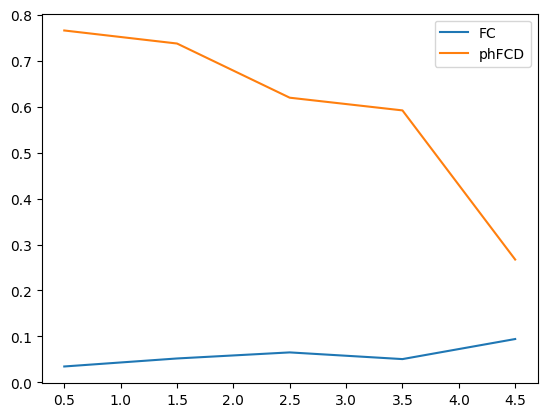

In [110]:
warmUp = True
warmUpFactor = 10.

subjectName = ''
conditionToStudy='hc'
mode = 'homogeneous'  # homogeneous/heterogeneous
# Since we haven't filtered the data in the previous step from Nilearn, we are going to filter them. 
distanceSettings = {'FC': (FC, True), 'phFCD': (phFCD, True)}
def computeSubjectSimulation():
    # integrator.neuronalModel.SC = C
    # integrator.initBookkeeping(N, Tmaxneuronal)
    if warmUp:
        currObsVars = integrator.warmUpAndSimulate(dt, Tmaxneuronal, TWarmUp=Tmaxneuronal/warmUpFactor)
    else:
        currObsVars = integrator.simulate(dt, Tmaxneuronal)
    # currObsVars = integrator.returnBookkeeping()  # curr_xn, curr_rn
    neuro_act = currObsVars[:,1,:]  # curr_rn
    return neuro_act
    
outFilePath = '/home/riccardo/Documents/Code/ADNI_Hopf_old/Results/G_fitted_to_HC-minimalWMH/Finding_the_best_G/filter_0.04-0.07_initial/'

Gs = np.round(np.arange(0.5,5,1),3)

def fittingPipeline_homogeneous(all_fMRI,
                    distanceSettings,  # This is a dictionary of {name: (distance module, apply filters bool)}
                    gs):
    print("\n\n###################################################################")
    print("# Fitting with ParmSeep")
    print("###################################################################\n")
    # Now, optimize all we (G) values: determine optimal G to work with
    gParms = [{'we': g} for g in gs]
    fitting = ParmSeep.distanceForAll_Parms(all_fMRI,
                                            Gs, 
                                            gParms,
                                            NumSimSubjects=1,
                                            distanceSettings=distanceSettings,
                                            parmLabel='finding_best_G_',
                                            outFilePath=outFilePath)

    optimal = {sd: distanceSettings[sd][0].findMinMax(fitting[sd]) for sd in distanceSettings}
    return optimal, fitting

BOLDfilters.flp = 0.008
BOLDfilters.fhi = 0.08
BOLDfilters.TR = 3.0
best_parameters, fitting = fittingPipeline_homogeneous(all_fMRI=all_fMRI, distanceSettings=distanceSettings, gs=Gs)

import matplotlib.pyplot as plt

for ds in distanceSettings:
          plt.plot(Gs, fitting[ds], label = ds)
          plt.legend()
          optimValDist = distanceSettings[ds][0].findMinMax(fitting[ds])
          parmPos = [a for a in np.nditer(Gs)][optimValDist[1]]
          print(f"# Optimal {ds} =     {optimValDist[0]} @ {np.round(parmPos, decimals=3)}")
plt.savefig(outFilePath + '/initial_exploration_plot.png')


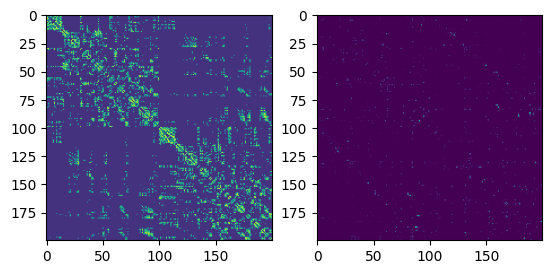

In [101]:
a = pd.read_csv('/home/riccardo/petTOAD/data/utils/sc_enigma.csv', header=None)
a.to_numpy()
#a[a<0] = 0
fig, axs = plt.subplots(1,2)

axs[0].imshow(a)
axs[1].imshow(sc)


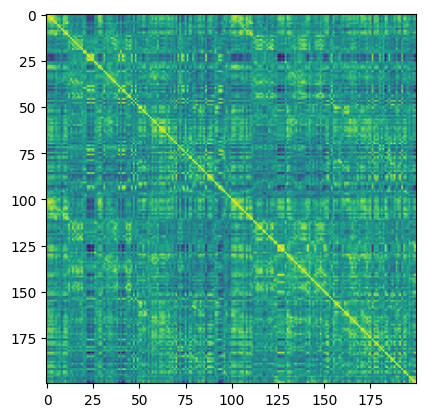

In [50]:
fneuromat = sio.loadmat('/home/riccardo/Documents/Code/ADNI_Hopf_old/Results/G_fitted_to_HC-minimalWMH/Finding_the_best_G/filter_0.04-0.07_initial/fNeuro_emp.mat')
fc = fneuromat['FC']
plt.imshow(fc)


# fneuromat = sio.loadmat('/home/riccardo/Documents/Code/ADNI_Hopf_old/Results/G_fitted_to_HC-minimalWMH/Finding_the_best_G/filter_0.008-0.08_initial/fNeuro_emp.mat')
# fc = fneuromat['FC']
# plt.imshow(fc)

In [32]:
import pandas as pd
a = pd.DataFrame(timeseries_prova)
c = a.index[a[0] == 0]

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
0,0.457405,0.996908,1.480638,-0.247974,-1.851205,0.527568,-1.337751,0.137689,0.909234,0.345974,...,0.267092,-0.125931,0.713716,1.735505,-0.162391,0.009641,-1.353590,0.344534,0.277515,0.041370
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.891639,-2.352925,1.168080,1.295272,0.589938,2.484068,-0.326015,1.236379,-0.244794,-0.106180,...,-0.592288,0.468371,2.147978,0.064289,-0.578094,-1.360804,-0.452638,-1.538097,1.090043,0.808720
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,-1.545794,0.177219,-0.660752,-0.410227,-1.225176,2.324497,0.517291,0.073151,0.294957,0.491293,...,0.044004,0.761371,0.109862,-0.785146,0.500334,0.222544,0.124275,-0.148788,-0.774768,-0.220824
